In [1]:
%load_ext autoreload
%autoreload 2

In [10]:
import os
from owi_data_2_pandas.io import API
import datetime
from pytz import utc
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# Import vub Meetenet Vlaamse Banken API functions
from vubmvbc.config import Credentials
from vubmvbc.client import Base
from vubmvbc.objects import Catalog, Data
import vubmvbc.data_getter as dg

from oma_tracking.oma_clustering import ModeClusterer
from oma_tracking.data.make_dataset import get_mpe_data
from oma_tracking.data.utils import read_simulations_csv_files
from oma_tracking.data import make_dataset


In [14]:
start =  datetime.datetime(2022,11,1,tzinfo=utc)
stop  = datetime.datetime(2023,5,4,tzinfo=utc)
end_date = datetime.datetime(2023,5,4,tzinfo=utc)
location = 'nw2d01'
name_location = 'NW2_D01'
home_folder = "../../../"
data_path = home_folder + "data/nw2/raw/" + location + "_" + start.strftime("%Y%m%d") + "_" + stop.strftime("%Y%m%d") + ".parquet"
weather_data_path = home_folder + "data/nw2/mvbc_data.parquet"
tracked_frequencies_path = home_folder + "data/nw2/tracked_modes/harmonics_removed/" + location + ".parquet"
simulations_data_path = home_folder + "data/nw2/simulations/" + location + "/"

turbine_data = pd.read_parquet(data_path).loc[:end_date]
turbine_data = turbine_data.loc[~turbine_data.index.duplicated(keep='first')]
weather_station_data_LAT = pd.read_parquet(weather_data_path).loc[:end_date]


# Get all the data
data = pd.read_parquet(data_path).loc[:end_date]
mvbc_data = pd.read_parquet(weather_data_path).loc[:end_date]
tracked_frequencies = pd.read_parquet(tracked_frequencies_path).loc[:end_date]
simulation_data = read_simulations_csv_files(simulations_data_path + "eigen_frequencies/")
simulation_shifts = read_simulations_csv_files(simulations_data_path + "mean_shifts/")
simulation_errors = pd.read_csv(simulations_data_path + "errors/Errors_No_scour.csv", index_col=0)


name_location = 'NW2_D01'
mpe_data = {}
directions = ['SS', 'FA']
for direction in directions:
    mpe_data[direction] = get_mpe_data(turbine_data, direction, name_location)

In [15]:
scada_inputs = make_dataset.get_scada_subset(data)
weather_data = mvbc_data[mvbc_data.columns[mvbc_data.isna().sum() < len(mvbc_data) * 0.1]]

In [16]:
inputs = \
    pd.concat(
        [
            weather_data,
            scada_inputs
        ],
        axis=1
    )

In [79]:
df1 = mpe_data['SS'].copy()
df2 = inputs.copy()
df2.rename_axis('timestamp', inplace=True)
merged_df = df1.merge(df2, on='timestamp', how='left')

In [84]:
merged_df.columns

Index(['algorithm', 'mean_damping', 'mean_frequency', 'size', 'std_damping',
       'std_frequency', 'mvbc_WandelaarBuoy_10%_highest_waves',
       'mvbc_WandelaarBuoy_Wave_height',
       'mvbc_WandelaarBuoy_Average_wave_period',
       'mvbc_WandelaarBuoy_Height_waves_with_period_>_10_s',
       'mvbc_WandelaarMeasuringpile_Max_3-seconds_wind_gust_(at_10_m_height)',
       'mvbc_WandelaarMeasuringpile_Average_wind_direction',
       'mvbc_WandelaarMeasuringpile_Average_wind_speed_(at_10_m_height)',
       'mvbc_WandelaarMeasuringpile_Tide_TAW',
       'mvbc_WandelaarMeasuringpile_Air_pressure',
       'mvbc_WandelaarMeasuringpile_Air_temperature', 'mean_NW2_D01_rpm',
       'mean_NW2_D01_yaw', 'mean_NW2_D01_pitch', 'mean_NW2_D01_power',
       'mean_NW2_D01_windspeed', 'mean_NW2_D01_winddirection'],
      dtype='object')

In [90]:
cols = ['mean_frequency', 'size', 'mean_damping', 'mean_NW2_D01_windspeed']
clustering_data = merged_df[cols].dropna()

In [91]:
mc = ModeClusterer(
    eps = 5,
    min_samples = 100,
    multipliers = {"mean_frequency": 200, "size": 1, "mean_damping": 1, 'mean_NW2_D01_windspeed': 1},
    cols = ['mean_frequency', 'size', 'mean_damping', 'mean_NW2_D01_windspeed'],
    min_size = 5.0,
    max_damping = 5.0
    )

In [93]:
mc.fit(clustering_data)

Text(0, 0.5, 'mean_frequency')

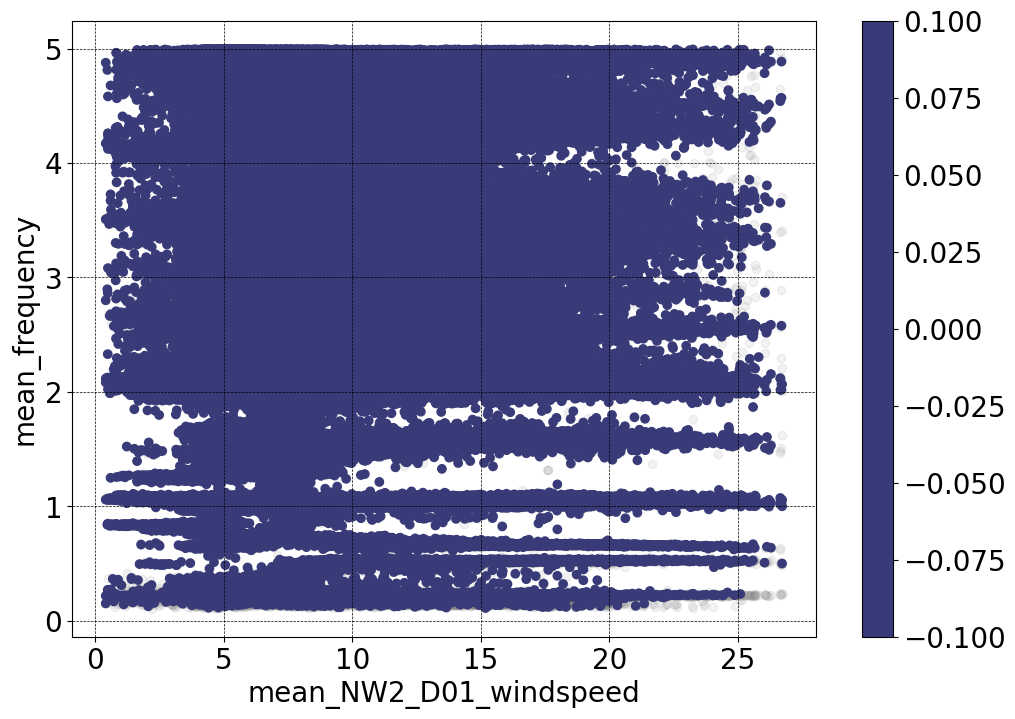

In [94]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
x_col = 'mean_NW2_D01_windspeed'
y_col = 'mean_frequency'
color_col = 'mean_NW2_D01_rpm'
clustered_modes = mc.predict(min_cluster_size=200)


fig = plt.figure(figsize = (12,8))
plt.scatter(clustering_data[x_col], clustering_data[y_col], alpha=0.1, color='grey')

tab = plt.get_cmap('tab20b')
first_colors = tab(range(0,len(clustered_modes.labels.unique()),1))
cmap = ListedColormap(first_colors)

plt.scatter(clustered_modes[x_col], clustered_modes[y_col], c=clustered_modes['labels'], cmap = cmap)
plt.grid(True, color='k', linestyle='--', linewidth=0.5)
cbar = plt.colorbar()
plt.xlabel(x_col)
plt.ylabel(y_col)
#plt.title('Tracked modes in the Z (SS) direction')

C:\Users\Max\AppData\Local\Temp\ipykernel_36288\1519492972.py:9: MatplotlibDeprecationWarning: The draw_all function was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use fig.draw_without_rendering() instead.
  cbar.draw_all()


Text(0, 0.5, 'mean_frequency')

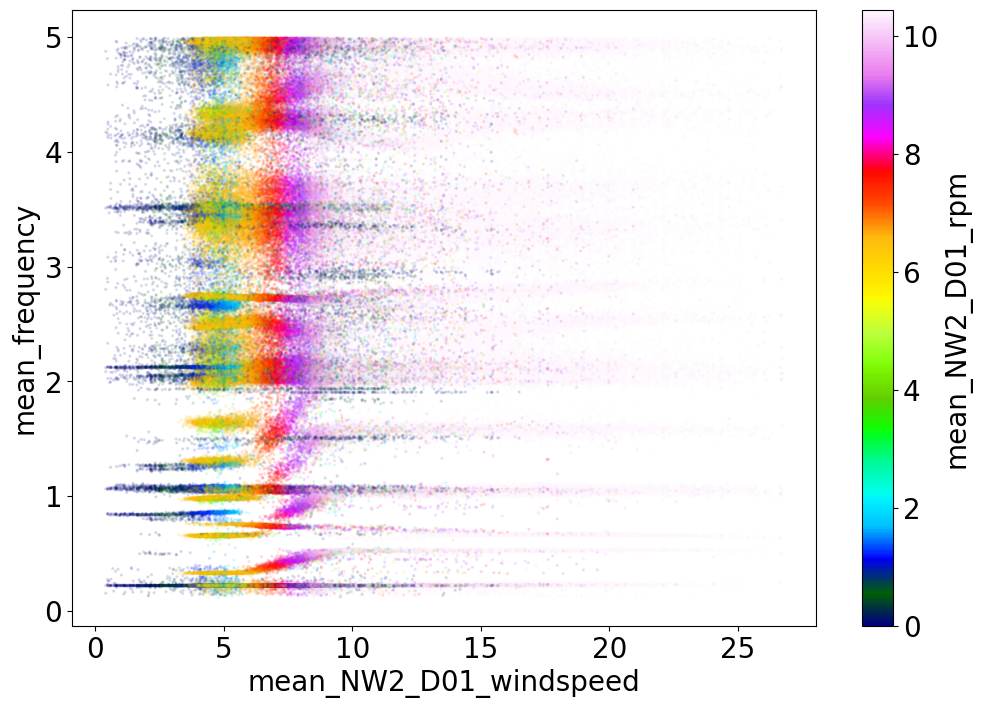

In [74]:
x_col = 'mean_NW2_D01_windspeed'
y_col = 'mean_frequency'
color_col = 'mean_NW2_D01_rpm'
plt.figure(figsize=(12, 8))
plt.scatter(merged_df[x_col], merged_df[y_col], c=merged_df[color_col], cmap='gist_ncar', alpha=0.1, s=2)
cbar = plt.colorbar()
cbar.ax.set_ylabel(color_col)
cbar.set_alpha(1)
cbar.draw_all()
cbar.set_alpha(1)
plt.xlabel(x_col)
plt.ylabel(y_col)

C:\Users\Max\AppData\Local\Temp\ipykernel_36288\649876344.py:9: MatplotlibDeprecationWarning: The draw_all function was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use fig.draw_without_rendering() instead.
  cbar.draw_all()


Text(0, 0.5, 'mean_frequency')

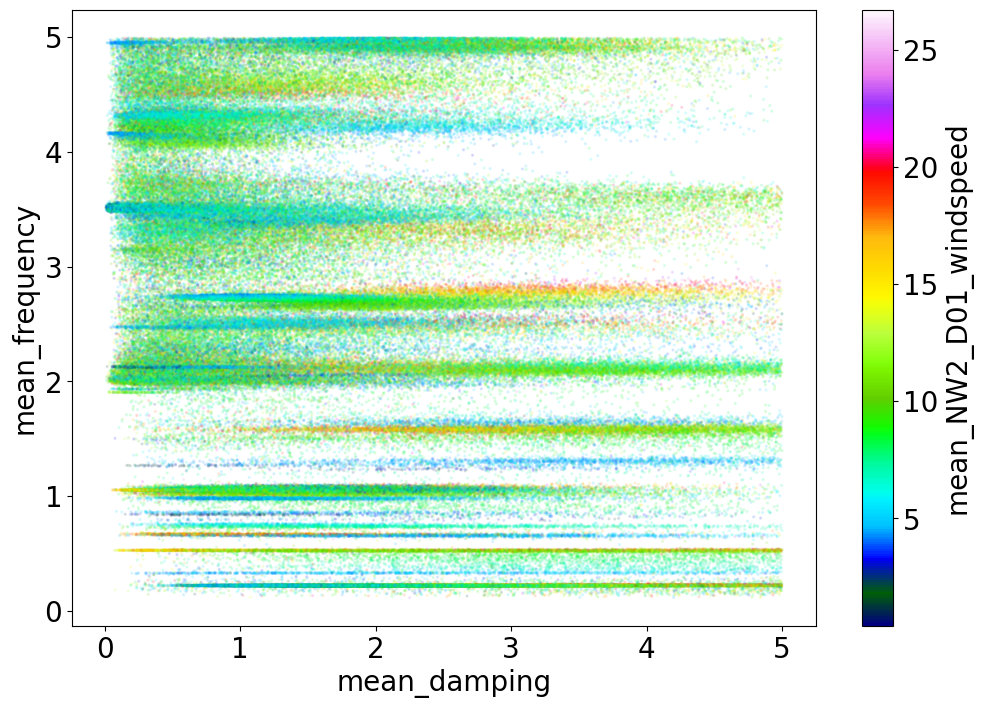

In [75]:
x_col = 'mean_damping'
y_col = 'mean_frequency'
color_col = 'mean_NW2_D01_windspeed'
plt.figure(figsize=(12, 8))
plt.scatter(merged_df[x_col], merged_df[y_col], c=merged_df[color_col], cmap='gist_ncar', alpha=0.1, s=2)
cbar = plt.colorbar()
cbar.ax.set_ylabel(color_col)
cbar.set_alpha(1)
cbar.draw_all()
cbar.set_alpha(1)
plt.xlabel(x_col)
plt.ylabel(y_col)

C:\Users\Max\AppData\Local\Temp\ipykernel_36288\579226963.py:9: MatplotlibDeprecationWarning: The draw_all function was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use fig.draw_without_rendering() instead.
  cbar.draw_all()


Text(0, 0.5, 'mean_frequency')

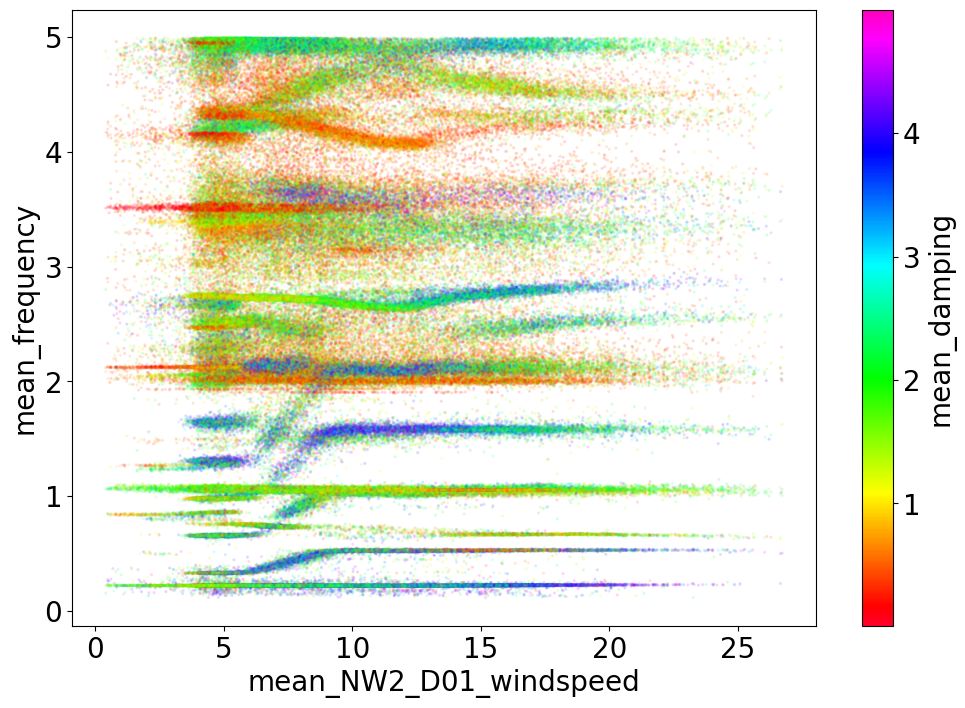

In [76]:
x_col = 'mean_NW2_D01_windspeed'
y_col = 'mean_frequency'
color_col = 'mean_damping'
plt.figure(figsize=(12, 8))
plt.scatter(merged_df[x_col], merged_df[y_col], c=merged_df[color_col], cmap='gist_rainbow', alpha=0.1, s=2)
cbar = plt.colorbar()
cbar.ax.set_ylabel(color_col)
cbar.set_alpha(1)
cbar.draw_all()
cbar.set_alpha(1)
plt.xlabel(x_col)
plt.ylabel(y_col)

In [71]:
df1 = mpe_data['FA'].copy()
df2 = inputs.copy()
df2.rename_axis('timestamp', inplace=True)
merged_df = df1.merge(df2, on='timestamp', how='left')
merged_df

algorithm  mean_damping  mean_frequency  size  \
timestamp                                                                 
2022-11-01 00:00:00+00:00      lscf      7.254620        0.177239    30   
2022-11-01 00:00:00+00:00      lscf      1.647232        0.526493    35   
2022-11-01 00:00:00+00:00      lscf      3.043577        1.079484    41   
2022-11-01 00:00:00+00:00      lscf      3.408727        1.606296    32   
2022-11-01 00:00:00+00:00      lscf      0.578061        2.030415    24   
...                             ...           ...             ...   ...   
2023-05-04 00:00:00+00:00      lscf      0.823535        1.987977    29   
2023-05-04 00:00:00+00:00      lscf      1.386231        2.119035    27   
2023-05-04 00:00:00+00:00      lscf      0.558410        2.431319    15   
2023-05-04 00:00:00+00:00      lscf      1.510134        3.341499    16   
2023-05-04 00:00:00+00:00      lscf      0.535864        4.727605    25   

                           std_damping  std_frequency  \
timestamp                                               
2022-11-01 00:00:00+00:00     0.342368       0.001141   
2022-11-01 00:00:00+00:00     0.279653       0.002441   
2022-11-01 00:00:00+00:00     0.274192       0.002655   
2022-11-01 00:00:00+00:00     0.325617       0.005390   
2022-11-01 00:00:00+00:00     0.188518       0.001193   
...                                ...            ...   
2023-05-04 00:00:00+00:00     0.278034       0.003701   
2023-05-04 00:00:00+00:00     0.119161       0.004729   
2023-05-04 00:00:00+00:00     0.126527       0.003735   
2023-05-04 00:00:00+00:00     0.146756       0.002063   
2023-05-04 00:00:00+00:00     0.161513       0.004100   

                           mvbc_WandelaarBuoy_10%_highest_waves  \
timestamp                                                         
2022-11-01 00:00:00+00:00                                 108.0   
2022-11-01 00:00:00+00:00                                 108.0   
2022-11-01 00:00:00+00:00                                 108.0   
2022-11-01 00:00:00+00:00                                 108.0   
2022-11-01 00:00:00+00:00                                 108.0   
...                                                         ...   
2023-05-04 00:00:00+00:00                                 115.0   
2023-05-04 00:00:00+00:00                                 115.0   
2023-05-04 00:00:00+00:00                                 115.0   
2023-05-04 00:00:00+00:00                                 115.0   
2023-05-04 00:00:00+00:00                                 115.0   

                           mvbc_WandelaarBuoy_Wave_height  \
timestamp                                                   
2022-11-01 00:00:00+00:00                            85.0   
2022-11-01 00:00:00+00:00                            85.0   
2022-11-01 00:00:00+00:00                            85.0   
2022-11-01 00:00:00+00:00                            85.0   
2022-11-01 00:00:00+00:00                            85.0   
...                                                   ...   
2023-05-04 00:00:00+00:00                            90.0   
2023-05-04 00:00:00+00:00                            90.0   
2023-05-04 00:00:00+00:00                            90.0   
2023-05-04 00:00:00+00:00                            90.0   
2023-05-04 00:00:00+00:00                            90.0   

                           mvbc_WandelaarBuoy_Average_wave_period  \
timestamp                                                           
2022-11-01 00:00:00+00:00                                    3.19   
2022-11-01 00:00:00+00:00                                    3.19   
2022-11-01 00:00:00+00:00                                    3.19   
2022-11-01 00:00:00+00:00                                    3.19   
2022-11-01 00:00:00+00:00                                    3.19   
...                                                           ...   
2023-05-04 00:00:00+00:00                                    4.40   
2023-05-04 00:00:00+0

C:\Users\Max\AppData\Local\Temp\ipykernel_36288\579226963.py:9: MatplotlibDeprecationWarning: The draw_all function was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use fig.draw_without_rendering() instead.
  cbar.draw_all()


Text(0, 0.5, 'mean_frequency')

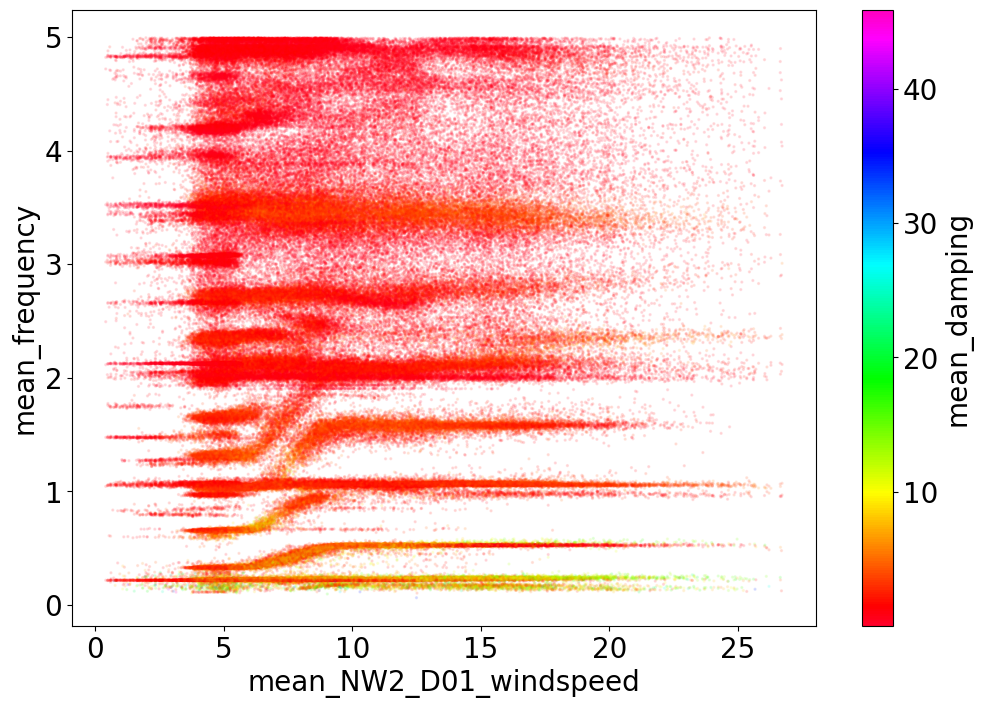

In [72]:
x_col = 'mean_NW2_D01_windspeed'
y_col = 'mean_frequency'
color_col = 'mean_damping'
plt.figure(figsize=(12, 8))
plt.scatter(merged_df[x_col], merged_df[y_col], c=merged_df[color_col], cmap='gist_rainbow', alpha=0.1, s=2)
cbar = plt.colorbar()
cbar.ax.set_ylabel(color_col)
cbar.set_alpha(1)
cbar.draw_all()
cbar.set_alpha(1)
plt.xlabel(x_col)
plt.ylabel(y_col)

In [ ]:
mc = ModeClusterer(
    eps = 5,
    min_samples = 100,
    multipliers = {"frequency": 40, "size": 0.5, "damping": 1},
    index_divider = 20000,
    cols = ['frequency', 'size', 'damping'],
    min_size = 5.0,
    max_damping = 5.0
    )

mean_NW2_D01_rpm    10.445
dtype: float64


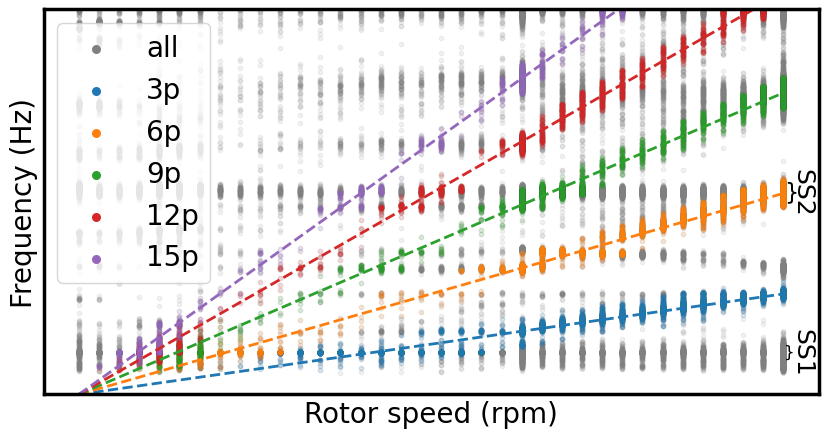

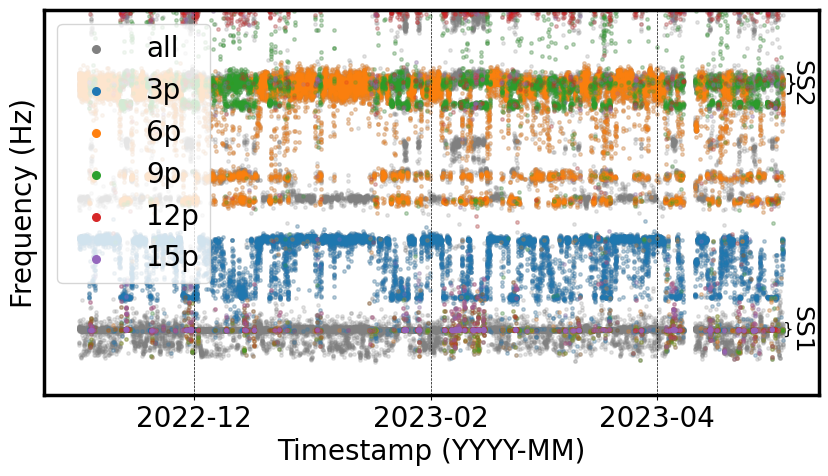

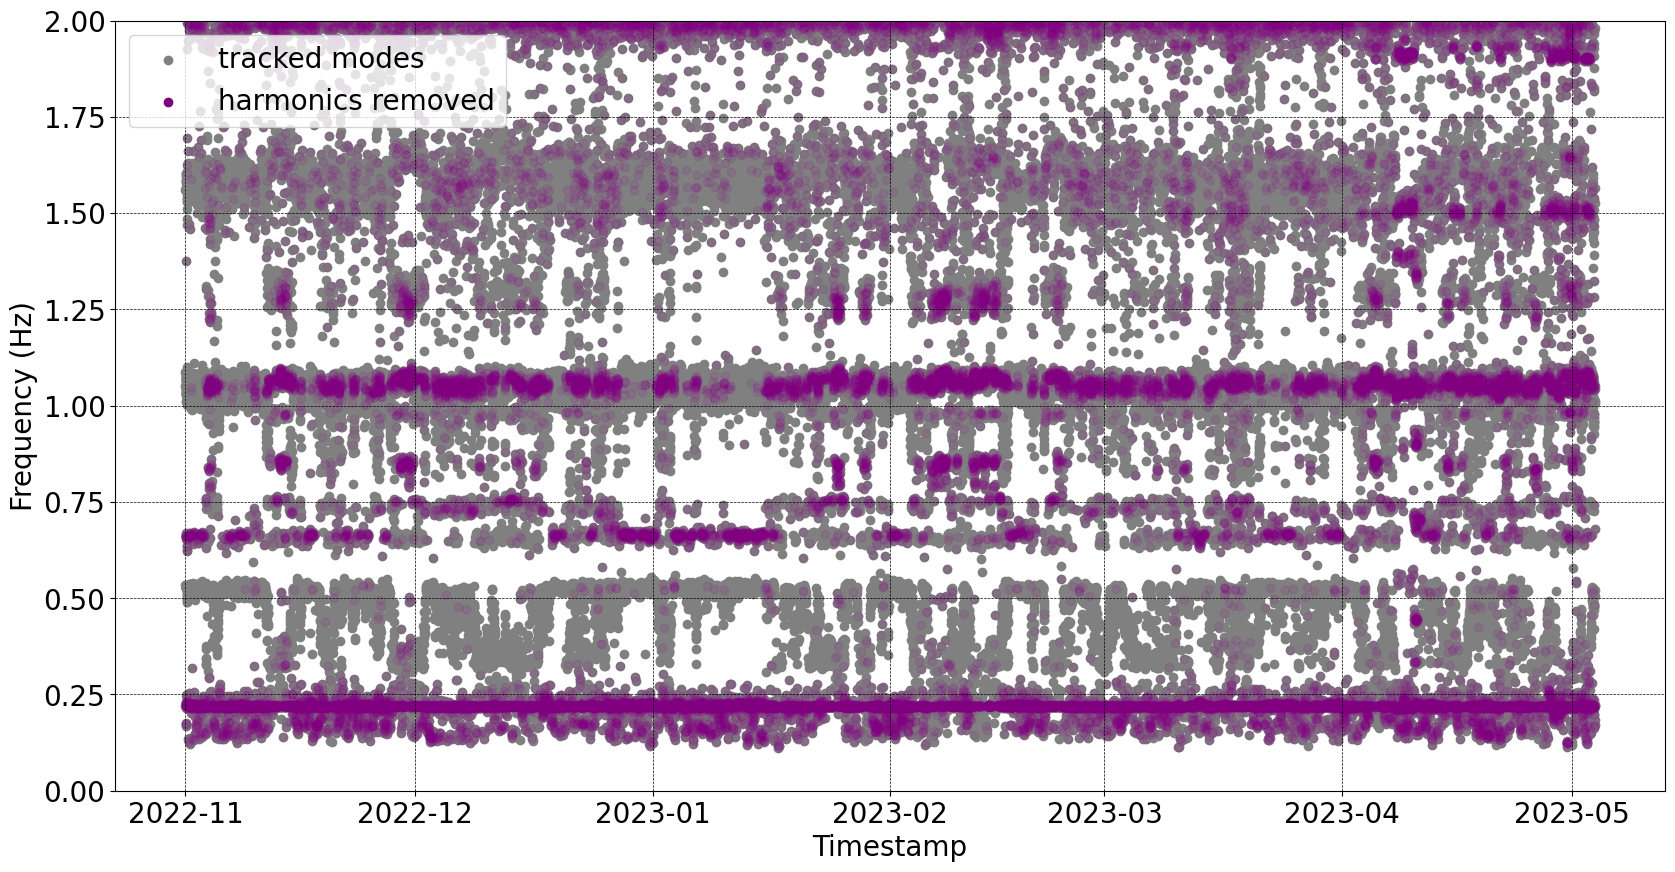

In [4]:
from oma_tracking.modal_tracking.harmonics import HarmonicDetector
plt.rcParams.update({'font.size': 20})
clustering_data = {}
harmonic_detectors = {}
harmonics_removed = {}
for direction in ['SS']:
    clustering_data[direction] = mpe_data[direction].rename(columns={'mean_frequency':'frequency', 'mean_damping':'damping', 'size':'size'})
    harmonic_detectors[direction] = HarmonicDetector(turbine_data, clustering_data[direction], min_rpm=0, max_distance = 0.08, p_orders=[3,6,9,12, 15])
    distance_calculator_data = harmonic_detectors[direction].get_distance_calculator_data()
    harmonic_detectors[direction].plot_distances()
    harmonic_detectors[direction].plot_harmonics_removed()
    harmonics_removed[direction] = harmonic_detectors[direction].remove_harmonics()